In [2]:
import os
import matplotlib.pyplot as plt 
import seaborn as sb
import scipy.io as sio
import scipy.signal as ssi
import argparse
import numpy as np
from pydfnc.compute_sliding_window import compute_sliding_window

def plot_vs(X1, X2):
    sb.set()
    fig1, ax1 = plt.subplots(1,2,figsize=(10,5))
    sb.lineplot(X1[0,:,0].T, ax=ax1[0])
    sb.lineplot(X2[0,:,0].T, ax=ax1[1])
    plt.show()

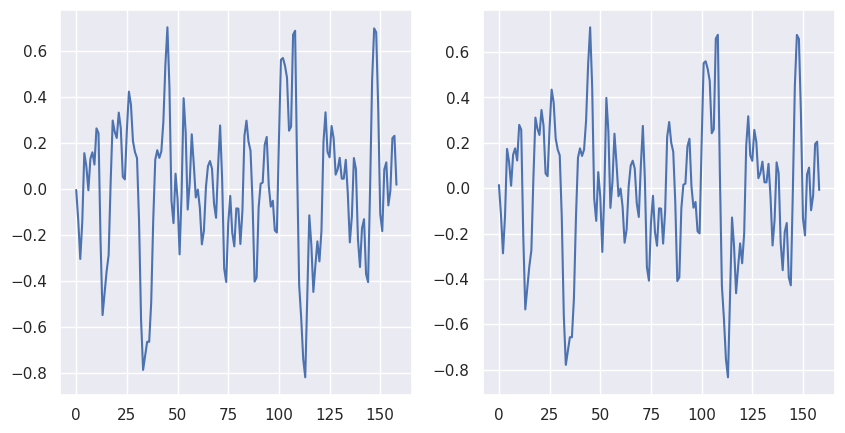

In [3]:
X = sio.loadmat("data/fbirn_tc.mat")["TC"]
X_detrend = ssi.detrend(X, axis=1, type="linear")
plot_vs(X, X_detrend)

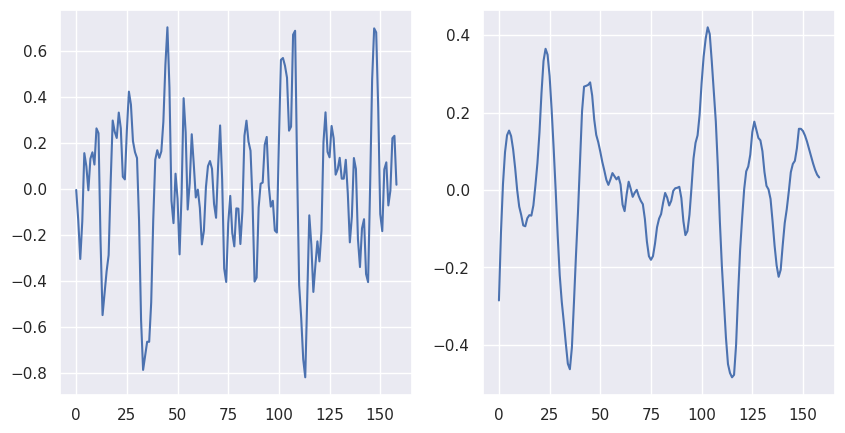

In [13]:
# This doesn't work
#TR = 2
#NyqF = (1/TR) / 2
#Wn = (0.15 / NyqF)
#print(Wn)
window_length = 20
X_savgol = ssi.savgol_filter(X_detrend, window_length, 3, axis=1) # window size 51, polynomial order 3
plot_vs(X, X_savgol)

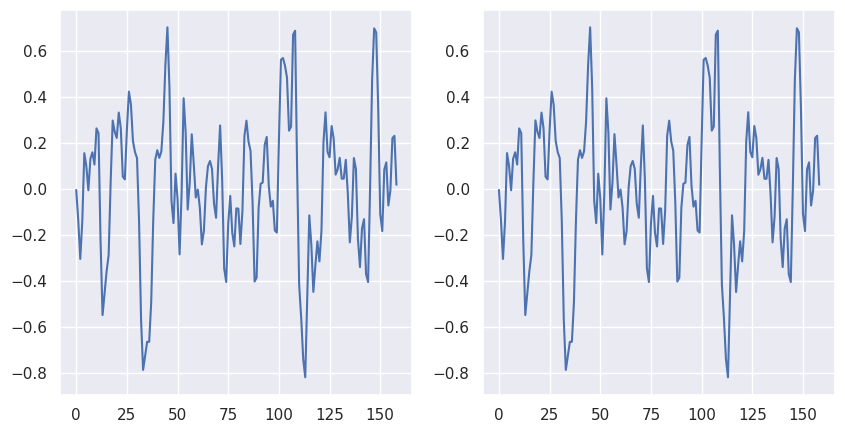

In [15]:
TR = 2
NyqF = (1/TR) / 2
HFcutoff = 0.15
Wn = (HFcutoff / NyqF)

bfilter, afilter = ssi.butter(5, Wn)
X_filter = ssi.filtfilt(bfilter, afilter, X)
plot_vs(X, X_filter)

In [16]:
X_to_use = X_filter
wsize=40
minTP = 159
window_alpha = 0.5
A = compute_sliding_window(minTP, window_alpha, wsize)
Nwin = minTP - wsize
window_steps = list(range(Nwin))
windows = np.zeros((X.shape[0], Nwin, minTP-1, X.shape[2]))
fncs = np.zeros((X.shape[0], Nwin, X.shape[2], X.shape[2]))
Ashift = A
for ii in range(Nwin):
    window = X_to_use[:, [int(i) for i in Ashift], :]
    for ns in range(X.shape[0]):
        corrs = np.corrcoef(window[ns].T.squeeze())
        fncs[ns, ii, :, :] = corrs
    windows[:, ii, :, :] = window
    Ashift = np.roll(A, -int(np.round(-minTP/2) + np.round(wsize/2) + window_steps[ii]))


(159,) (160, 1)


In [17]:
from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import random_center_initializer, kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric
print(fncs.shape)
def corr_dist(x, y):
    return np.corrcoef(x, y)[0][1]
X_for_cluster = fncs.reshape(fncs.shape[0]*fncs.shape[1], fncs.shape[2]*fncs.shape[3])
#km = KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=100, tol=1e-6, algorithm='lloyd')
#kmC = km.fit(X_for_cluster)
initial_centers = random_center_initializer(X_for_cluster, 5, random_state=5).initialize()
#initial_centers = kmeans_plusplus_initializer(X_for_cluster, 5, 4).initialize()
# instance created for respective distance metric
instanceKm = kmeans(X_for_cluster, initial_centers=initial_centers, metric=distance_metric(type_metric.USER_DEFINED, func=corr_dist))
# perform cluster analysis
instanceKm.process()

(314, 119, 47, 47)


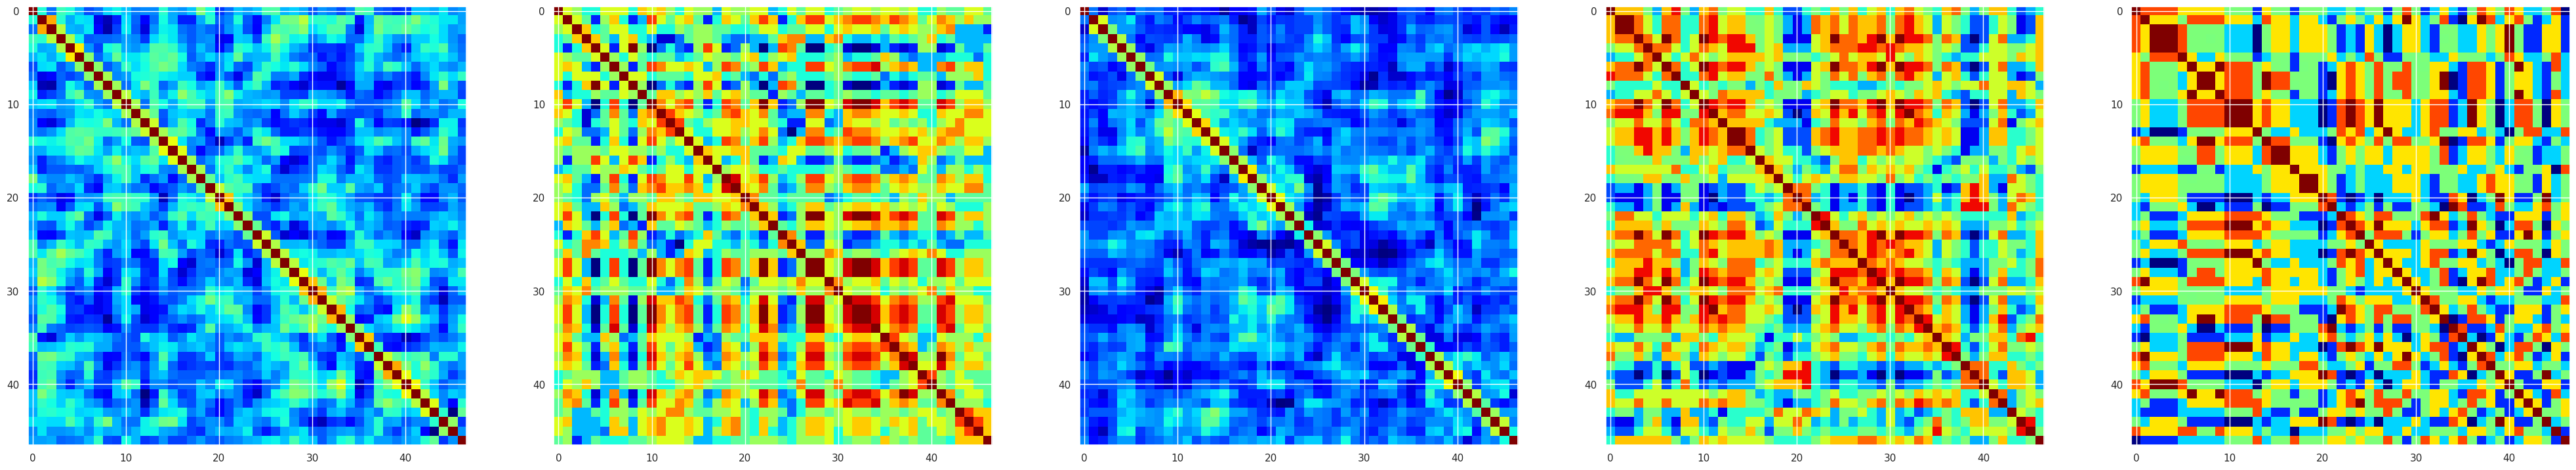

In [24]:
labels = instanceKm.get_clusters()
centers = instanceKm.get_centers()
#print(labels.shape)
#print(centers.shape)
fig, ax = plt.subplots(1, 5, figsize=(50, 10))
for ii in range(5):
    kC = instanceKm._kmeans__centers[ii, :].reshape(47,47)
    ax[ii].imshow(kC, cmap="jet")
plt.show()